# Figure 1b: SRAL Ku-band sea ice waveform


Figure 1a-d illustrate key steps in the NaRRS snow depth and SIT processing chain and are combined with a flow chart to create Figure 1 in the manuscript. 

Here we will plot an example of a Ku-band waveform returned from sea ice to SRAL, and illustrate some of the parameters extracted from the waveform to investigate as potential snow depth predictors.

**Data required**
* Sentinel-3 SAR-processed waveform. This could be from the orginial Sentinel-3 L2 dataset, but here we extract the waveform from a preprocessed (using pysiral) dataset that includes the parameters of interest already extracted. This is so that we can check for consistency between the extraction performed here and that done previously at large-scale for the study. The file this notebook defaults to work with is NaRRS/Data/pysiral-l1p-sentinel3a-l2_lan_si-rep-north-20190301T052353-20190301T053158-waveform_features.nc.

**Software required**

To generate this figure, the pysiral toolbox is required (https://github.com/pysiral/pysiral).

1) Import required packages

In [1]:
import sys
sys.path.append('/home/cn/pysiral')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pysiral.retracker.tfmra import cTFMRA
from pysiral.waveform import TFMRALeadingEdgeWidth, WaveFormTrailingEdgeParameter, WaveFormTrailingEdgeDecayFit
from cftime import num2pydate
from joblib import Parallel, delayed

2) Define functions

In [2]:
def get_waveform_features_ds_simplified(fpath):
    
    """
    Function to read the pysrial-processed Sentinel-3 L2 Sea Ice Thematic Dataset""
    
    Parameters:
    fpath (str): File path to the NetCDF4 file containing the pysiral (L1P) file.
    
    Returns:
    xr.Dataset: Merged xarray Dataset containing classifier, time_orbit, and waveform data with appropriate renaming and coordinate assignment.
    """
       
    classifer_ds = xr.open_dataset(fpath, group ='classifier')
    orbit_ds = xr.open_dataset(fpath, group ='time_orbit', drop_variables=['altitude', 'altitude_rate', 'antenna_pitch', 'antenna_roll', 'antenna_yaw', 'antenna_mispointing', 'orbit_flag'])
    wf_ds = xr.open_dataset(fpath, group ='waveform')
    ds = xr.merge([classifer_ds, orbit_ds,  wf_ds], join='inner')
    ds =  ds.rename_dims({'n_records': 'time_20_ku'})
    ds = ds.assign_coords({'time_20_ku':num2pydate(ds['timestamp'].values, units="seconds since 1970-01-01 00:00:00.0")})
    ds = ds.rename_vars({'latitude': 'lat_20_ku', 'longitude': 'lon_20_ku'})
    
    def convert_lon_easting_format(longitude):
        if longitude >180 and longitude <= 360:
            longitude = longitude - 360
        return longitude

    ds['lon_20_ku'] = (('time_20_ku'),Parallel(n_jobs=20, prefer="threads")(delayed(convert_lon_easting_format)(longitude) for longitude in ds['lon_20_ku'].values))
    ds = ds.sortby('time_20_ku').drop_vars(['timestamp'])
    return  ds

3) Load an example pysiral-processed file containing the variables extracted from each waveform and select a fing waveform from the file to focus on

In [3]:
fpath = '../Data/pysiral-l1p-sentinel3a-l2_lan_si-rep-north-20190301T052353-20190301T053158-waveform_features.nc'
#load the dataset
s3_waveform_ds = get_waveform_features_ds_simplified(fpath)
#select a waveform to work with
selected_wf = s3_waveform_ds.isel(time_20_ku=5700)

#prepare radar_mode and retrack_flag
radar_mode = np.array([selected_wf['radar_mode'].values.astype(np.int32)])
is_valid =  np.array([selected_wf['is_valid'].values.astype(np.int32)])

4) Extract the waveform from the dataset

In [4]:
#extract the waveform and range bins
waveform = selected_wf['power'].values
range_bins = np.arange(len(waveform))
range_bins_m = selected_wf['range'].values #in meters

#normalize the waveform
unnormed_waveform = waveform
waveform = waveform / np.max(waveform)

5) Extract waveform parameters

In [5]:
#locate the peak and first maximum index
peak_index = np.argmax(waveform)
peak_power = waveform[peak_index] #should be 1 after normalization

#by default, the first maximum threshold is set to 0.15 in pysiral (cTFMRA)
fmi_threshold = 0.15
fmi_index = cTFMRA.get_first_maximum_index(waveform, fmi_threshold)
fmi_power = waveform[fmi_index]

#configuration options for the TFMRA retracker
tfmra_options = {
    "noise_level_range_bin_idx": [0, 5],
    "wfm_oversampling_factor": 10,
    "wfm_smoothing_window_size": [11, 11, 21],
    "first_maximum_normalized_threshold": [0.15, 0.15, 0.45],
    "first_maximum_ignore_leading_bins": 0,
}

#calculate the leading edge width using TFMRA
leading_edge_start_threshold = 0.05
leading_edge_end_threshold = 0.95

#first in bins
width_bins = TFMRALeadingEdgeWidth(range_bins.reshape(1, -1), waveform.reshape(1, -1), radar_mode, is_valid, tfmra_options=tfmra_options)
leading_edge_width, leading_edge_start_bin, leading_edge_start_power, leading_edge_end_bin, leading_edge_end_power = width_bins.get_width_from_thresholds(leading_edge_start_threshold, leading_edge_end_threshold, return_all_values=True)

#then in meters (so we can check against the procesed dataset)
width_meters = TFMRALeadingEdgeWidth(range_bins_m.reshape(1, -1), waveform.reshape(1, -1), radar_mode, is_valid, tfmra_options=tfmra_options)
leading_edge_width_m, _, _, _, _ = width_meters.get_width_from_thresholds(leading_edge_start_threshold, leading_edge_end_threshold, return_all_values=True)

#ensure consistency with the orginal product
assert np.isclose(leading_edge_width_m[0], selected_wf['leading_edge_width'].values, atol=0.001)
print(f"Leading Edge Width (m): {leading_edge_width_m[0]:.2f} (Dataset: {selected_wf['leading_edge_width'].values:.2f})")

#calculate the trailing edge width and decay
tew_options = {
    "valid_first_maximum_index_range": [10, 246],
    "trailing_edge_width": {
        "oversample_factor": 10,
        "trailing_edge_end_power_treshold_normed": 0.05
    }
}

trailing_edge = WaveFormTrailingEdgeParameter(waveforms=waveform.reshape(1, -1), 
                                               valid_first_maximum_index_range=tew_options["valid_first_maximum_index_range"],
                                               trailing_edge_width_kwargs=tew_options["trailing_edge_width"])

waveform_trailing_edge_data = trailing_edge.get_waveform_trailing_edge_data(trailing_edge.waveforms[0,:])
trailing_edge_decay_data = trailing_edge.get_trailing_edge_decay(waveform_trailing_edge_data,  WaveFormTrailingEdgeDecayFit().fit(waveform_trailing_edge_data)) #this will also add the results to the trailing_edge object

#ensure consistency with the orginal product
assert np.isclose(trailing_edge.params.tew[0],  selected_wf['trailing_edge_width'].values, atol=0.001)
print(f"Trailing Edge Width (bins): {trailing_edge.params.tew[0]:.2f} (Dataset: {selected_wf['trailing_edge_width'].values:.2f})")

assert np.isclose(trailing_edge.params.ted[0],  selected_wf['trailing_edge_decay'].values, atol=0.001)
print(f"Trailing Edge Decay: {trailing_edge.params.ted[0]:.2f} (Dataset: {selected_wf['trailing_edge_decay'].values:.2f})")

Leading Edge Width (m): 1.81 (Dataset: 1.81)


Trailing Edge Width (bins): 75.00 (Dataset: 75.00)
Trailing Edge Decay: 0.40 (Dataset: 0.40)


6) Assign variables

In [6]:
#assign variables
trailing_edge_start_index = waveform_trailing_edge_data.trailing_edge_start_idx
lower_envelope_range_bins = trailing_edge_start_index + waveform_trailing_edge_data.trailing_edge_lower_envelope_idx
lower_envelope_values = waveform_trailing_edge_data.waveform_trailing_edge_subset_lower_envelope
trailing_edge_range_bins = waveform_trailing_edge_data.waveform_trailing_edge_idx
trailing_edge_fit_values = waveform_trailing_edge_data.trailing_edge_fit
trailing_edge_width = trailing_edge.params.tew[0]
trailing_edge_decay = trailing_edge.params.ted[0]

7) Plot and annotate the waveform

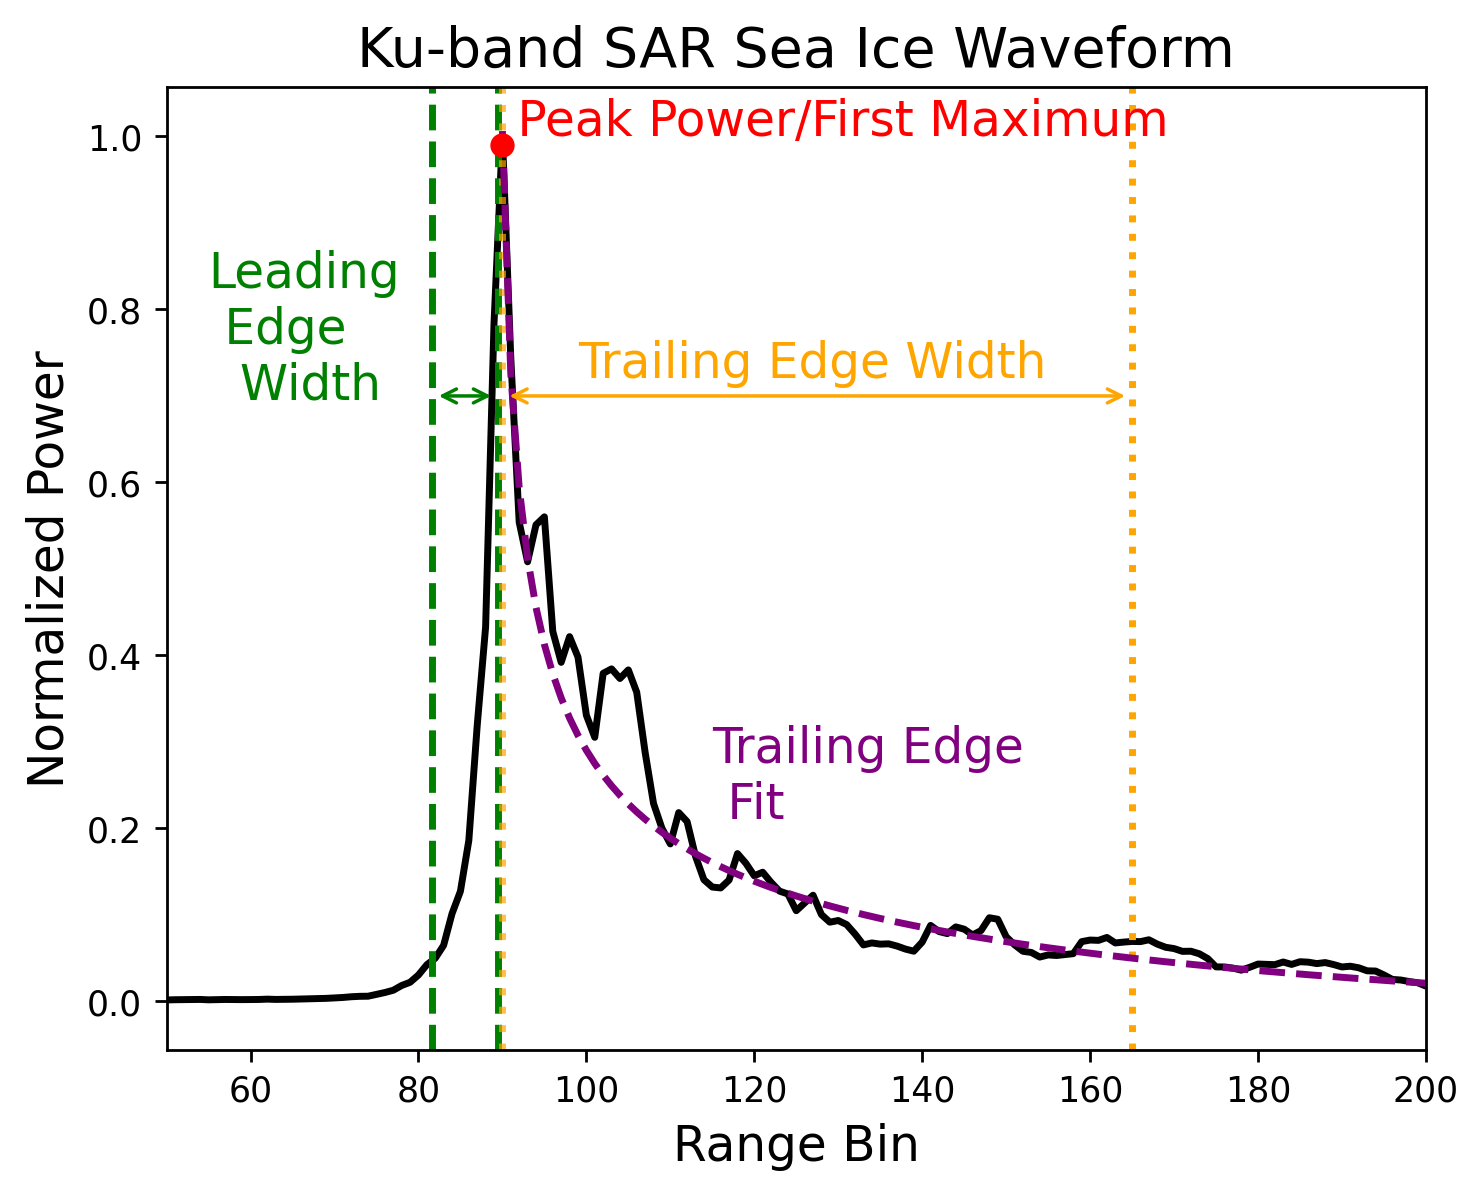

In [7]:
fig = plt.figure(figsize=(6.5, 5), dpi=250)
ax = fig.add_subplot(111)
ax.plot(range_bins, waveform, label='Original Waveform', color='k', linewidth=2)
ax.set_xlabel('Range Bin', fontsize=14)
ax.set_ylabel('Normalized Power', fontsize=14)
ax.set_title('Ku-band SAR Sea Ice Waveform', fontsize=16)

#annotate leading edge width
ax.axvline(x=leading_edge_start_bin[0], color='g', linestyle='--',  linewidth=2)
ax.axvline(x=leading_edge_end_bin[0], color='g', linestyle='--', linewidth=2)
#add a horizontal line with arrowed ends to illustrate the leading edge width
ax.annotate('', xy=(leading_edge_end_bin[0], 0.7), xytext=(leading_edge_start_bin[0], 0.7),
                arrowprops=dict(arrowstyle='<->', color='g'))
ax.text(55 ,0.685, 'Leading\n Edge\n  Width', color='g', verticalalignment='bottom', fontsize=14)

#annotate trailing edge width
ax.axvline(x=trailing_edge_start_index, color='orange', linestyle=':', linewidth=2, alpha=0.7)
ax.axvline(x=(trailing_edge_start_index + trailing_edge_width), color='orange', linestyle=':', linewidth=2)
#add a horizontal line with arrwed ends to show the trailing edge width
ax.annotate('', xy=((trailing_edge_start_index + trailing_edge_width), 0.7), xytext=(trailing_edge_start_index, 0.7),
                arrowprops=dict(arrowstyle='<->', color='orange'))
ax.text(99, 0.71, 'Trailing Edge Width', color='orange', verticalalignment='bottom', fontsize=14)

#plot the trailing edge decay fit
ax.plot(trailing_edge_range_bins, trailing_edge_fit_values, 'purple', linewidth=2, linestyle='--')
ax.text(115, 0.2, 'Trailing Edge\n Fit', color='purple', verticalalignment='bottom', fontsize=14)
# ax.plot(lower_envelope_range_bins, fitted_trailing_edge, 'orange', linestyle='--', label='Trailing Edge Decay Fit', linewidth=2,)
# ax.text(110, 450, 'Trailing Edge\n Decay Fit', color='orange', verticalalignment='bottom', fontsize=10)

if fmi_index != peak_index:
    # # Annotate peak power
    ax.plot(range_bins[peak_index], peak_power, 'fuchsia', marker= 'o')
    ax.text(range_bins[peak_index], peak_power, ' Peak Power', verticalalignment='bottom', fontsize=14, color='fuchsia')
else:
    # # Annotate peak power
    ax.plot(range_bins[peak_index], peak_power-0.01, 'red', marker= 'o')
    ax.text(range_bins[peak_index], peak_power-0.01, ' Peak Power/First Maximum', verticalalignment='bottom', fontsize=14, color='red')
    
#plot the lower envelope points
# ax.scatter(lower_envelope_range_bins, lower_envelope_values, color='purple', label='Lower Envelope Points', s=20)
# ax.text(100, 5, 'Lower Envelope Points', color='purple', verticalalignment='bottom', fontsize=10)
# ax.legend()
# # Show plot
ax.set_xlim(50, 200)
# ax.grid(True)
plt.savefig('ku_band_waveform_features_example.png', dpi=200, bbox_inches='tight', transparent=True)
plt.show()